In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from get_features import *

In [2]:
# def model_city(df, city = 1):
#     '''
#     Breaks the dataset into 3 cities
#     SF = 1
#     OAK = 2
#     SJ = 3

#     INPUT: DataFrame
#            Number for city to be modeled
#     OUTPUT: returns a portion of the original dataframe
#     ''' 
#     if city == 1:
#         return df[(df.end_station_latitude > 37.697799) & (df.end_station_longitude <-122.330676)]
#     elif city == 2:
#         return df[(df.end_station_latitude > 37.697799) & (df.end_station_longitude >-122.330676)]
#     elif city == 3:
#         return df[df.end_station_latitude < 37.697799]
    
def unique_stations(df):
    '''
    Given a dataframe, identify the unique start/end stations
    
    INPUT: DataFrame
    OUTPUT: 1 array of unique start station ids
  
    '''
    #names of each start station and the number of trips 
    lst_start_station_name = df.start_station_name.value_counts()
    #ids of each start station and the number of trips 
    lst_start_station_id = df.start_station_id.value_counts()
    num_unique_stations = lst_start_station_id.unique().size
    unique_start_sations = df.start_station_id.unique()
    unique_end_stations = df.end_station_id.unique()
    return unique_start_sations







    

In [3]:
df = pd.read_csv('data/201803-fordgobike-tripdata.csv')
mar_18_sf = model_city(df)
mar_18= unique_stations(mar_18_sf)
np.sort(mar_18)

array([  3,   4,   5,   6,   8,   9,  10,  11,  13,  14,  15,  16,  17,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        33,  34,  36,  37,  39,  41,  42,  43,  44,  45,  47,  49,  52,
        53,  55,  56,  58,  59,  60,  61,  62,  63,  64,  66,  67,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  84,  85,
        86,  88,  89,  90,  93,  95,  96,  97,  98,  99, 100, 101, 102,
       105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 132, 133, 134,
       137, 138, 139, 140, 141, 144, 145, 146, 147, 148, 155, 163, 223,
       284, 285, 321, 323, 324, 336, 342, 343])

In [4]:
df = pd.read_csv('data/201804-fordgobike-tripdata.csv')
apr_18_sf = model_city(df)
apr_18= unique_stations(apr_18_sf)
np.sort(apr_18)

array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  13,  14,  15,  16,
        17,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  33,  34,  36,  37,  39,  41,  42,  43,  44,  45,  47,  49,
        50,  52,  53,  55,  56,  58,  59,  60,  61,  62,  63,  64,  66,
        67,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        84,  85,  86,  88,  89,  90,  93,  95,  96,  97,  98,  99, 100,
       101, 102, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 132,
       133, 134, 137, 138, 139, 140, 141, 144, 145, 146, 147, 223, 230,
       231, 239, 284, 285, 321, 323, 324, 336, 342, 343, 344, 345])

In [4]:


def new_stn_ids(old_stn, new_stn):
    '''
    INPUT: 2 lists. 1 list of new station ids
                    1 list of old station ids
    '''
    new_stn = set(new_stn) - set(old_stn)
    lst_new = list(new_stn)
    return lst_new



In [6]:
proposed_stn = new_stn_ids(mar_18, apr_18)
proposed_stn

[230, 231, 7, 239, 50, 344, 345]

In [5]:
df_2017 = pd.read_csv('data/2017-fordgobike-tripdata.csv')
df_2017 = feature_addition(df_2017)


In [31]:
#df = pd.read_csv('data/master-fordgobike-tripdata.csv')

In [32]:
#df = feature_addition(df)

In [33]:
df_2018 = pd.read_csv('data/201804-fordgobike-tripdata.csv')
df_2018 = feature_addition(df_2018)

In [6]:
#separate the months
#cdf will be current month
#ndf will be next month
cdf = month_sep(df_2017, 2017, 11)
ndf = month_sep(df_2017, 2017, 12)

In [7]:
#find the unique stations for each month
cus = unique_stations(cdf)
nus = unique_stations(ndf)

In [8]:
len(cus)

254

In [9]:
len(nus)

267

In [10]:
#list of proposed stations
#stations opened in next month but not in current month
ps = new_stn_ids(cus, nus)

In [40]:
ps

[258, 292, 293, 294, 263, 267, 268, 237, 269, 337, 338, 339, 340, 254]

In [11]:
def stn_coords(df):
    #getting the coordinates from the dataset
    coordinates = np.array(df[['start_station_longitude', 'start_station_latitude']])
    unique_coords = np.unique(coordinates, axis = 0)
    #create a dictionary with
    #station id as key
    #coordinates for the station id as values
    id_coord = {}
    for u in unique_coords:
        k = df.start_station_id[(df.start_station_longitude == u[0]) &(df.start_station_latitude == u[1])].iloc[0]
        id_coord[k] = u
    return id_coord




In [12]:
def plot_new_station(df, new_stn):
#     print("The origin station is {}.".format(t))
#     print("The 3 closest neighbors are: {}, {}, {}".format(int(knn_dict.get(t)[0]),int(knn_dict.get(t)[1]),int(knn_dict.get(t)[2])))
    id_coord = stn_coords(df)
    plt.figure(figsize = (10,10))
    ll,rr = -122.50, -122.36
    bb = 37.73
    plt.xlim(ll,rr)
    plt.ylim(bb, bb+(rr-ll))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Map of Ford GoBike stations at the end of April 2018")
    plt.scatter(df.start_station_longitude, df.start_station_latitude, s=1, c=('r'))
    for n in new_stn:
#         if id_coord.get(n) is not None:
        plt.scatter(id_coord.get(n)[0], id_coord.get(n)[1], s=20, marker='x', c=('b'))
#         else:
#             print ("Station {} has been removed.".format(n))

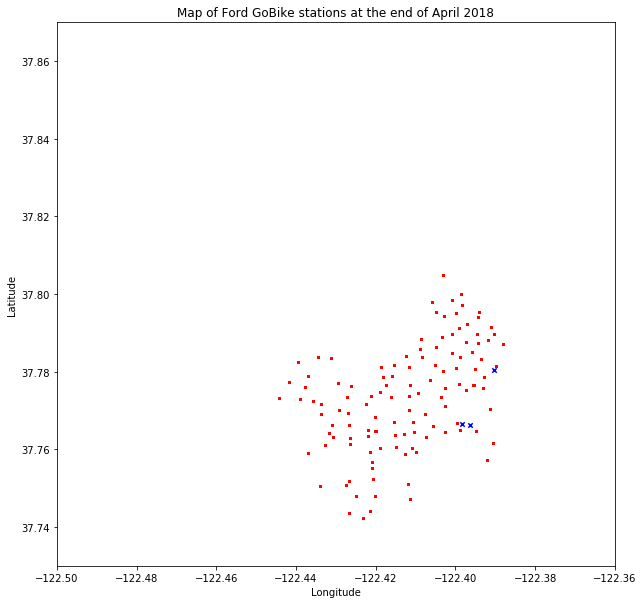

In [9]:
plot_new_station(apr_18_sf, proposed_stn)

In [30]:
proposed_stn

[230, 231, 7, 239, 50, 344, 345]

### Use knn to pick stations from current month that are closest to each proposed station

In [13]:
def euclidean_distance(x, y):
    return np.sqrt(((x-y)**2).sum(axis=1))

In [14]:
def knn_proposed_stn(df, df2, proposed_stn, num_neighbors = 3):
    

    coordinates = np.array(df[['start_station_longitude', 'start_station_latitude']])
    unique_coords = np.unique(coordinates, axis = 0)
    #get the id and coords for current month
    id_coord_df = stn_coords(df)
    id_coord_df2 = stn_coords(df2)
    knn_dict = {}
    for p in proposed_stn:
        neighbors = unique_coords[np.argsort(euclidean_distance(id_coord_df2.get(p), unique_coords))][1:num_neighbors+1]
#         k = df.start_station_id[(df.start_station_longitude == id_coord_df2.get(p)[0]) &(df.start_station_latitude == id_coord_df2.get(p)[1])].iloc[0]
        v = []
        for i in range(num_neighbors):
            knn_id = df.start_station_id[(df.start_station_longitude == neighbors[i][0]) &(df.start_station_latitude == neighbors[i][1])].iloc[0]
            v.append(knn_id)
        knn_dict[p] = v
    return knn_dict

In [15]:
knn_proposed_stn(cdf, ndf, ps)

{258: [244, 247, 246],
 292: [290, 304, 289],
 293: [307, 308, 283],
 294: [287, 327, 208],
 263: [270, 259, 251],
 267: [240, 243, 248],
 268: [266, 274, 18],
 237: [228, 227, 226],
 269: [266, 248, 239],
 337: [182, 183, 181],
 338: [162, 202, 183],
 339: [186, 201, 162],
 340: [169, 188, 274],
 254: [238, 245, 246]}

In [16]:
cdf.month.unique()[0]

11

### Time series by day

In [17]:
#3 month history for specific station
#current month and 2 previous month
cm = cdf.month.unique()[0]
tsdf = df_2017[(df_2017.month <=cm) & (df_2017.month>cm-3)]


In [27]:
tsdf

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,member_birth_year,member_gender,day_of_week,date,year,month,day,hour,malfunction,age
83695,76635,2017-11-30 19:54:03.465,2017-12-01 17:11:19.3150,120,Mission Dolores Park,37.761420,-122.426435,28,The Embarcadero at Bryant St,37.787168,...,NaN,NaN,3,2017-11-30,2017,11,30,19,False,NaN
84835,58723,2017-11-30 19:53:27.124,2017-12-01 12:12:10.2220,120,Mission Dolores Park,37.761420,-122.426435,44,Civic Center/UN Plaza BART Station (Market St ...,37.781074,...,NaN,NaN,3,2017-11-30,2017,11,30,19,False,NaN
86540,893,2017-11-30 23:55:38.015,2017-12-01 00:10:31.4650,20,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,79,7th St at Brannan St,37.773492,...,1987.0,Male,3,2017-11-30,2017,11,30,23,False,32.0
86541,852,2017-11-30 23:54:42.997,2017-12-01 00:08:55.2870,308,San Pedro Square,37.336802,-121.894090,297,Locust St at Grant St,37.322980,...,1976.0,Female,3,2017-11-30,2017,11,30,23,False,43.0
86542,2142,2017-11-30 23:31:19.432,2017-12-01 00:07:02.4280,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,34,Father Alfred E Boeddeker Park,37.783988,...,NaN,NaN,3,2017-11-30,2017,11,30,23,False,NaN
86543,896,2017-11-30 23:49:33.532,2017-12-01 00:04:30.2760,41,Golden Gate Ave at Polk St,37.781270,-122.418740,134,Valencia St at 24th St,37.752428,...,NaN,NaN,3,2017-11-30,2017,11,30,23,False,NaN
86544,793,2017-11-30 23:51:12.854,2017-12-01 00:04:26.1500,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,99,Folsom St at 15th St,37.767037,...,1985.0,Male,3,2017-11-30,2017,11,30,23,False,34.0
86545,504,2017-11-30 23:55:45.622,2017-12-01 00:04:10.1830,13,Commercial St at Montgomery St,37.794231,-122.402923,24,Spear St at Folsom St,37.789677,...,1980.0,Male,3,2017-11-30,2017,11,30,23,False,39.0
86547,795,2017-11-30 23:45:26.865,2017-11-30 23:58:42.2080,112,Harrison St at 17th St,37.763847,-122.413004,86,Market St at Dolores St,37.769305,...,1991.0,Male,3,2017-11-30,2017,11,30,23,False,28.0
86548,1745,2017-11-30 23:28:01.127,2017-11-30 23:57:07.0850,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,239,Bancroft Way at Telegraph Ave,37.868813,...,1969.0,Other,3,2017-11-30,2017,11,30,23,False,50.0


In [28]:
months = np.sort(tsdf.month.unique())

In [29]:
months

array([ 9, 10, 11])

In [35]:
days = np.zeros(1)
days

array([0.])

In [31]:
for idx, mon in enumerate(months):
    mult = idx+1
    

In [36]:
tsdf['days'] = 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [40]:
tsdf['days'][tsdf.month == 11] = tsdf.day * 2

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:8672: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [45]:
def days_for_ts(df, cdf):
    cm = cdf.month.unique()[0]
    tsdf = df_2017[(df_2017.month <=cm) & (df_2017.month>cm-3)]
    tsdf['days'] = 1
    months = np.sort(tsdf.month.unique())
    for idx, mon in enumerate(months):
        mult = idx+1
        tsdf['days'][tsdf.month == mon] = tsdf.day * mult
    return tsdf

In [46]:
ts = days_for_ts(df_2017, cdf)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:8672: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.6/site

In [101]:
ts['days'][ts.end_station_id == 246].value_counts()

30    21
8     21
12    20
18    18
24    18
4     17
14    15
57    13
6     13
22    12
1     12
84    12
60    12
16    11
21    11
10    11
9     11
20    11
52    10
3     10
15     9
54     9
42     9
26     9
27     9
28     9
36     9
23     8
25     7
39     7
48     7
87     6
29     6
45     6
50     6
2      6
56     6
19     6
7      6
34     5
81     5
63     5
11     5
5      4
72     4
90     4
66     4
62     4
32     4
40     4
51     4
17     3
13     3
75     3
46     2
58     2
78     1
33     1
38     1
44     1
Name: days, dtype: int64

In [92]:
def plt_stn(df, station_id):
    tsplt = df['days'][df.end_station_id == station_id].value_counts().reset_index()
    plt.scatter(np.array(tsplt)[:,0], np.array(tsplt)[:,1])
    return tsplt

,index,days
0,30,21
1,8,21
2,12,20
3,18,18
4,24,18
5,4,17
6,14,15
7,57,13
8,6,13
9,22,12


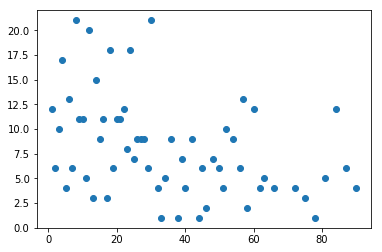

In [97]:
plt_stn(ts, 246)

In [93]:
ts[ts.end_station_id == 304]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,member_gender,day_of_week,date,year,month,day,hour,malfunction,age,days
86664,465,2017-11-30 21:47:32.520,2017-11-30 21:55:17.9580,308,San Pedro Square,37.336802,-121.894090,304,Jackson St at 5th St,37.348759,...,Male,3,2017-11-30,2017,11,30,21,False,46.0,90
86795,768,2017-11-30 20:23:41.222,2017-11-30 20:36:29.9230,312,San Jose Diridon Station,37.329732,-121.901782,304,Jackson St at 5th St,37.348759,...,Male,3,2017-11-30,2017,11,30,20,False,37.0,90
87180,806,2017-11-30 18:40:43.640,2017-11-30 18:54:09.6500,276,Julian St at The Alameda,37.332233,-121.912517,304,Jackson St at 5th St,37.348759,...,NaN,3,2017-11-30,2017,11,30,18,False,NaN,90
87419,439,2017-11-30 18:09:02.884,2017-11-30 18:16:22.3140,309,San Jose City Hall,37.337391,-121.886995,304,Jackson St at 5th St,37.348759,...,Female,3,2017-11-30,2017,11,30,18,False,62.0,90
88559,629,2017-11-30 14:34:47.844,2017-11-30 14:45:17.2550,318,San Carlos St at Market St,37.330698,-121.888979,304,Jackson St at 5th St,37.348759,...,Male,3,2017-11-30,2017,11,30,14,False,37.0,90
90959,554,2017-11-29 21:19:17.586,2017-11-29 21:28:32.5200,308,San Pedro Square,37.336802,-121.894090,304,Jackson St at 5th St,37.348759,...,Male,2,2017-11-29,2017,11,29,21,False,46.0,87
91047,691,2017-11-29 20:42:29.542,2017-11-29 20:54:01.1440,313,Almaden Blvd at San Fernando St,37.331415,-121.893200,304,Jackson St at 5th St,37.348759,...,Male,2,2017-11-29,2017,11,29,20,False,41.0,87
91601,802,2017-11-29 18:23:05.116,2017-11-29 18:36:27.3430,312,San Jose Diridon Station,37.329732,-121.901782,304,Jackson St at 5th St,37.348759,...,Female,2,2017-11-29,2017,11,29,18,False,33.0,87
95361,682,2017-11-28 20:02:18.014,2017-11-28 20:13:40.4210,313,Almaden Blvd at San Fernando St,37.331415,-121.893200,304,Jackson St at 5th St,37.348759,...,Male,1,2017-11-28,2017,11,28,20,False,41.0,84
96547,86,2017-11-28 17:02:37.583,2017-11-28 17:04:04.3430,289,5th St at Taylor St,37.351017,-121.895921,304,Jackson St at 5th St,37.348759,...,Male,1,2017-11-28,2017,11,28,17,False,54.0,84
